# Comparación de Modelos

## Predicción Posición Final de un Piloto

### Lectura de Datos

In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import make_scorer, mean_absolute_error , mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

df = pd.read_csv('../data/train/f1_position_prediction_dataset.csv')
df.head()

,raceId,driverId,constructorId,circuitId,year,round,positionOrder,qualifying_position,gap_to_pole,driver_age,standing_before,wins_before,constructor_points_before,constructor_wins_before,country,alt,driver_avg_position_at_circuit,driver_best_position_at_circuit,driver_races_at_circuit
0,18,1,1,1,2008,1,1,1.0,0.000,23.186858,49.0,2.0,71.0,2.0,Australia,10,5.750000,1,16
1,18,2,2,1,2008,1,2,5.0,0.522,30.850103,19.0,0.0,36.0,0.0,Australia,10,10.363636,2,11
2,18,3,3,1,2008,1,3,7.0,1.973,22.718686,34.5,0.0,34.5,0.0,Australia,10,8.636364,1,11
3,18,4,4,1,2008,1,4,12.0,NaN,26.631075,26.0,0.0,26.0,0.0,Australia,10,6.526316,1,19
4,18,5,1,1,2008,1,5,3.0,0.365,26.406571,22.0,0.0,71.0,2.0,Australia,10,13.833333,5,6


### Preprocesamiento

En el preprocesamiento tenemos muchas columnas. Vamos a identificar que podemos hacer con todos ellas:

In [105]:
target = 'positionOrder'
numeric_features = ['year', 'round', 'qualifying_position', 'gap_to_pole', 'driver_age', 'standing_before',
                    'wins_before', 'constructor_points_before', 'constructor_wins_before', 'alt', 'driver_avg_position_at_circuit', 
                    'driver_races_at_circuit', 'driver_best_position_at_circuit',]

categorical_features = ['country', 'driverId', 'constructorId', 'circuitId']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

X = df.drop(columns=[target])
y = df[target]

### Comparación de Modelos

Vamos a comparar como funcionan 4 modelos para este tipo de predicción.

- LinearRegression
- RandomForestRegressor
- GradientBoostingRegressor
- SVR

Evaluaremos estos modelos con la métrica MAE (Error absoluto medio).

Evaluando Linear Regression...
Evaluando Random Forest...


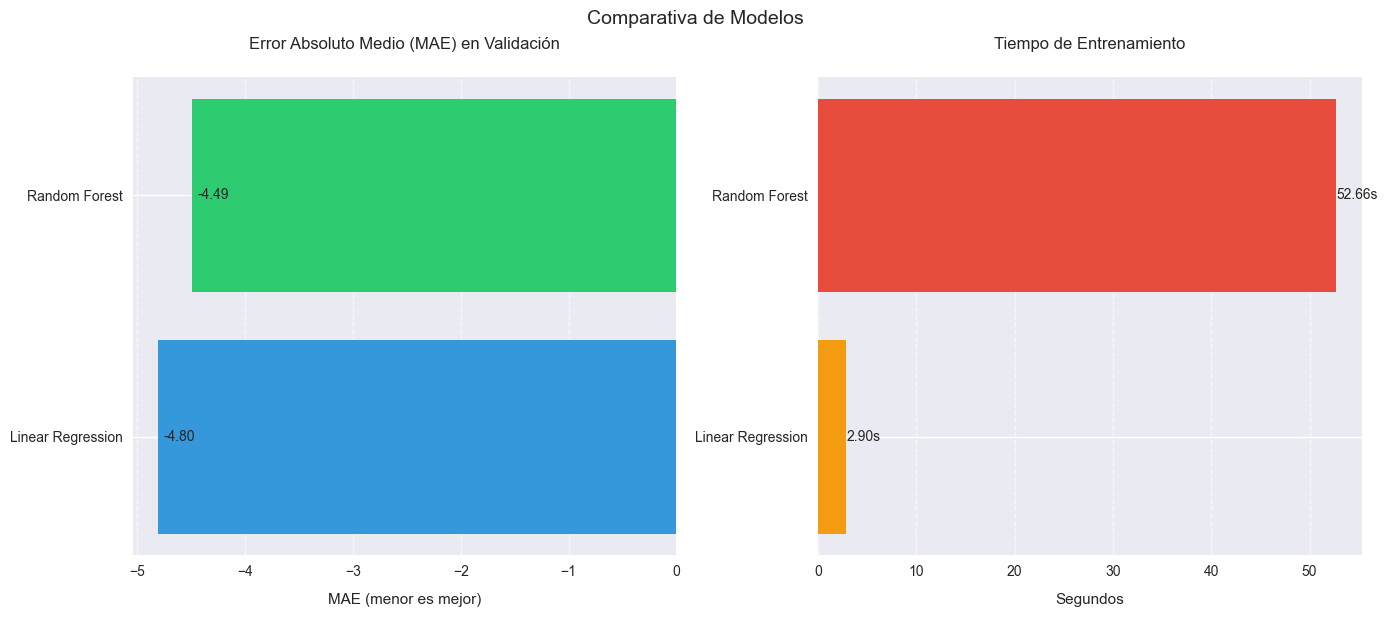

In [109]:
scoring = {
    'mae': make_scorer(mean_absolute_error), 
}
cv = 3

models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42, n_estimators=100, min_samples_split=2, min_samples_leaf=1, max_features='sqrt', max_depth=None, n_jobs=-1)
}

results = {}
for name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    print(f"Evaluando {name}...")
    start_time = time.time()
    cv_results = cross_validate(
        pipeline, X, y, cv=cv, scoring=scoring,
        return_train_score=True, n_jobs=1
    )
    
    elapsed_time = time.time() - start_time
    results[name] = {
        'test_mae': -cv_results['test_mae'].mean(),
        'fit_time': elapsed_time,
        'model': model  # Guardar el modelo para no tener que reentrenar
    }
    
results_df = pd.DataFrame(results).T
results_df = results_df.sort_values(by='test_mae')

import matplotlib.pyplot as plt
import numpy as np

# Configuración del estilo
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.facecolor'] = 'white'

# Crear figura
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Gráfico 1: Comparación de MAE
mae_bars = ax1.barh(results_df.index, results_df['test_mae'], color=['#3498db', '#2ecc71'])
ax1.set_title('Error Absoluto Medio (MAE) en Validación', pad=20)
ax1.set_xlabel('MAE (menor es mejor)', labelpad=10)
ax1.xaxis.grid(True, linestyle='--', alpha=0.6)

# Añadir valores en las barras
for bar in mae_bars:
    width = bar.get_width()
    ax1.text(width + 0.05, bar.get_y() + bar.get_height()/2, 
             f'{width:.2f}', 
             ha='left', va='center')

# Gráfico 2: Tiempo de entrenamiento
time_bars = ax2.barh(results_df.index, results_df['fit_time'], color=['#f39c12', '#e74c3c'])
ax2.set_title('Tiempo de Entrenamiento', pad=20)
ax2.set_xlabel('Segundos', labelpad=10)
ax2.xaxis.grid(True, linestyle='--', alpha=0.6)

# Añadir valores en las barras
for bar in time_bars:
    width = bar.get_width()
    ax2.text(width + 0.05, bar.get_y() + bar.get_height()/2, 
             f'{width:.2f}s', 
             ha='left', va='center')

# Ajustes finales
plt.tight_layout()
plt.suptitle('Comparativa de Modelos', y=1.02, fontsize=14)
plt.show()

In [108]:
param_grid = {
    'model__n_estimators': [50, 100],
    'model__max_depth': [None, 10],
    'model__min_samples_split': [2, 5],
    'model__min_samples_leaf': [1, 2],
    'model__max_features': ['sqrt']
}

rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(random_state=42, n_jobs=-1, warm_start=True))
])

from sklearn.model_selection import RandomizedSearchCV
rf_search = RandomizedSearchCV(
    rf_pipeline, param_distributions=param_grid, n_iter=8, cv=cv,
    scoring='neg_mean_absolute_error', n_jobs=1, random_state=42, verbose=1, return_train_score=True
)
rf_search.fit(X, y)

print(f"Mejores parámetros: {rf_search.best_params_}")
print(f"Mejor MAE: {-rf_search.best_score_:.3f}")

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Mejores parámetros: {'model__n_estimators': 100, 'model__min_samples_split': 2, 'model__min_samples_leaf': 1, 'model__max_features': 'sqrt', 'model__max_depth': None}
Mejor MAE: 4.490


### Predicciones

